In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from collections import Counter
from sklearn import tree
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import time

from sklearn.multiclass import OneVsRestClassifier

In [2]:
# load features
X_1 = pd.read_csv("X_1st_batch.csv")

# load targets
y_all = pd.read_csv("y_alldata.csv")
y_all.columns = ['Time_stamp', 'Activity']

In [3]:
#load presence features (simulate usage of estimote sensors, who can detect the presence
# in the rooom using highest RSSI value)
presence = pd.read_csv("presence_alldata.csv")
presence.columns = [u'Time_stamp', u'Pres_bath', u'Pres_kitch', u'Pres_bed']

In [4]:
# remove duplicate features (hour of the day)
del X_1['bed_feat.csv_Hour']
del X_1['cupboard_feat.csv_Hour']
del X_1['fridge_feat.csv_Hour']
del X_1['rice_feat.csv_Hour']
del X_1['showerH_feat.csv_Hour']
del X_1['showerT_feat.csv_Hour']
del X_1['stove_feat.csv_Hour']

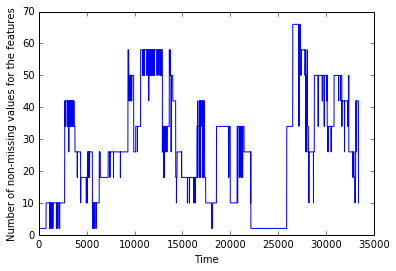

In [5]:
# visualize how many features are not missing over time
feature_viz = []
for i in xrange(X_1.shape[0]):
    feature_viz.append(X_1.shape[1] - np.sum(X_1.iloc[i,:].isnull()))

plt.plot(feature_viz)
plt.xlabel('Time')
plt.ylabel('Number of non-missing values for the features')
plt.show()

In [6]:
# merge features and presence
X_1p = pd.merge(X_1, presence, how = 'inner', on = "Time_stamp")

In [7]:
# merge feature/presence with target. So that we can drop NaN values while
# keeping a correspondance between row and target
X_1y = pd.merge(X_1p, y_all, how = 'inner', on = "Time_stamp")
print X_1y.shape

(33406, 70)


In [8]:
# select full days where there are not too many missing values
# WARNING: the selection was made by hand, based on the visualization of the non-missing values.
# this step may be dropped in the final system, where there will be many missing values anyway

idx = [range(0,9239),range(14999,26519), range(32279,X_1.shape[0])]
idxx = [item for sublist in idx for item in sublist]

X1y_dropna = X_1y.drop(idxx, axis = 0, inplace= False)


In [9]:
# get labels for the supervised learning
y_1 = X1y_dropna['Activity']

# remove columns that are not features we want to use for classification
# 'Pres_kitch', 'Pres_bath', 'Pres_bed'   are optional to remove
try:
    X1y_dropna.drop(['Activity', 'Time_stamp', 'Pres_kitch', 'Pres_bath', 'Pres_bed'], axis=1, inplace =True)
except ValueError:
    print "Value Error"
    pass
# , 'Pres_kitch', 'Pres_bath', 'Pres_bed'

In [11]:
# fill in missing values
imp = Imputer()
X1y_imp = imp.fit_transform(X1y_dropna)

In [12]:
X1_final = pd.DataFrame(X1y_imp)

In [13]:
# create a mapping between string labels and integers that will be the classes

mapping = {'Change':0, 'Cook':1, 'Eat':2, 'Other':0, 'Rice cooker':1, 'Shower':3, 'Sleep':4,
       'TV':5, 'Toilet':6}
y_1.replace(mapping, inplace = True)
#y_2.replace(mapping, inplace = True)

In [14]:
print Counter(y_1)
#print Counter(y_2)

Counter({0: 8122, 4: 3236, 2: 61, 1: 39, 3: 39, 6: 23})


In [15]:
print X1_final.shape
print y_1.shape

(11520, 65)
(11520L,)


# Train classifiers

In [16]:
clf = tree.DecisionTreeClassifier()
scores = cross_validation.cross_val_score(clf, X1_final, y_1, cv=10)
print scores
print np.mean(scores)

[ 0.56190476  0.66811092  0.79184735  0.70920139  0.76388889  0.65104167
  0.89661164  0.7767159   0.46133797  0.53437772]
0.681503820763


In [17]:
## Split the dataset into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X1_final, y_1, test_size=0.25, random_state=2)

In [18]:
# Train and decision tree
clf_dt = tree.DecisionTreeClassifier(max_depth=20)
clf_dt.fit(X_train,y_train)
y_pred_dt = clf_dt.predict(X_test)
foo = confusion_matrix(y_pred_dt, y_test)
foo

array([[1996,    3,    3,    6,   13,    4],
       [   1,    8,    2,    0,    0,    0],
       [   5,    2,   10,    0,    0,    0],
       [   7,    0,    0,    3,    1,    0],
       [  17,    0,    0,    0,  787,    1],
       [  10,    0,    0,    1,    0,    0]])

In [19]:
# Random forest
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)
foo = confusion_matrix(y_pred_rf, y_test)
foo

array([[2033,    3,    2,    7,    8,    4],
       [   0,    9,    1,    0,    0,    0],
       [   0,    1,   12,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0],
       [   3,    0,    0,    1,  793,    1],
       [   0,    0,    0,    0,    0,    0]])

In [20]:
# Random forest - predict probabilities - change decision boundary
clf_rf2 = RandomForestClassifier(n_estimators=100)
clf_rf2.fit(X_train,y_train)
y_pred_rf_prob = clf_rf2.predict_proba(X_test)

In [21]:
pred_categories = np.zeros_like(y_test)
for i in xrange(len(y_test)):
    if y_pred_rf_prob[i][3]>.15:  # shower
        pred_categories[i] = 3
    elif y_pred_rf_prob[i][5] > .1: #toilet
        pred_categories[i] = 6
    elif y_pred_rf_prob[i][1] > .30:
        pred_categories[i] =1
    elif y_pred_rf_prob[i][2] >.10:
        pred_categories[i] = 2
    elif y_pred_rf_prob[i][4] >.6:
        pred_categories[i] = 4

In [22]:
confusion_matrix(pred_categories, y_test)

array([[2011,    1,    1,    4,   13,    4],
       [   0,   12,    2,    0,    0,    0],
       [   7,    0,   12,    0,    0,    0],
       [   8,    0,    0,    6,    0,    0],
       [   3,    0,    0,    0,  788,    1],
       [   7,    0,    0,    0,    0,    0]])

{'Change': 0,
 'Cook': 1,
 'Eat': 2,
 'Other': 0,
 'Rice cooker': 1,
 'Shower': 3,
 'Sleep': 4,
 'TV': 5,
 'Toilet': 6}

In [23]:
# change weight in cost function

In [24]:
weights = {0:.01,1:1e10,2:1e10,3:1e20,4:1e5,6:1e15}

In [25]:
# random forest with uneven weights
clf_rf2 = RandomForestClassifier(n_estimators=100, class_weight=weights)
clf_rf2.fit(X_train,y_train)
y_pred_rf2 = clf_rf2.predict(X_test)
foo = confusion_matrix(y_pred_rf2, y_test)
foo

array([[ 206,    0,    0,    0,    0,    0],
       [  63,   12,    1,    0,    0,    0],
       [ 126,    0,   14,    0,    0,    0],
       [ 599,    0,    0,   10,  250,    1],
       [   7,    0,    0,    0,   62,    0],
       [1035,    1,    0,    0,  489,    4]])

In [26]:
# Adaboost
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=50, class_weight=weights),
    n_estimators=1000,
    learning_rate=.1)

In [27]:
start = time.time()
bdt.fit(X_train,y_train)
end = time.time()
print "duration", end-start 

duration 384.217000008


In [28]:
pred_bdt = bdt.predict(X_test)
cm_bdt = confusion_matrix(pred_bdt, y_test)

In [29]:
cm_bdt

array([[2031,    5,    4,    8,    8,    4],
       [   0,    7,    1,    0,    0,    0],
       [   1,    1,   10,    0,    0,    0],
       [   0,    0,    0,    1,    0,    0],
       [   3,    0,    0,    1,  793,    1],
       [   1,    0,    0,    0,    0,    0]])

In [30]:
# OVA strategy
classif = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
classif.fit(X_train,y_train)
y_pred_ova = classif.predict(X_test)
confusion_matrix(y_pred_ova, y_test)

array([[2032,    3,    1,    7,    7,    4],
       [   0,   10,    0,    0,    0,    0],
       [   0,    0,   14,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0],
       [   4,    0,    0,    1,  794,    1],
       [   0,    0,    0,    0,    0,    0]])

In [226]:
partition = []
for i in xrange(4):
    partition.append(range(i*2*1440,(i+1)*2*1440))

In [227]:
#y_1.iloc[partition[1],]
y = y_1.reset_index()
del y['index']

In [228]:
# error rate function
def accuracy(pred_labels, true_labels):
    acc= sum(pred_labels==true_labels)/float(len(true_labels)) * 100
    return acc

In [230]:
scores = []
for idx in partition:
    X_test = X1_final.iloc[idx,:]
    y_test = y.iloc[idx,:]
    train = [item for s in partition if s is not idx for item in s]
    X_train = X1_final.iloc[train,:]
    y_train = y.iloc[train,:]
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy(y_pred,np.asarray(y_test).ravel()))
    print np.unique(y_test), np.unique(y_pred)
    print confusion_matrix(y_pred, np.asarray(y_test).ravel())
print scores

print np.mean(scores)

[0 3 4 6] [0 3 4 6]
[[1846   13  291    7]
 [  44    0    0    0]
 [ 156    1  515    0]
 [   1    1    5    0]]
[0 3 4 6] [0 1 2 3 4 6]
[[1539    0    0    6  675    4]
 [  21    0    0    0    9    0]
 [   2    0    0    0    1    0]
 [ 162    0    0    0  334    2]
 [  34    0    0    0   61    0]
 [  29    0    0    0    1    0]]
[0 1 2 3 4 6] [0 1 2 3 4 6]
[[1576   18   29    2  953    3]
 [  20    0    0    0    0    0]
 [   6    0    0    0    0    0]
 [  70    0    0    4    4    0]
 [ 175    0    0    0   16    0]
 [   4    0    0    0    0    0]]
[0 1 2 3 4 6] [0 3 4 6]
[[1745   10   16    8   51    3]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   7    0    0    3    0    0]
 [ 674   11   16    1  320    4]
 [  11    0    0    0    0    0]]
[81.979166666666671, 55.555555555555557, 55.416666666666671, 71.805555555555557]
66.1892361111


In [25]:
# count the number of occurences of each activity (eg nights of sleeping)

cook = 0
sleep = 0
eat = 0
toilet = 0
shower = 0

#bar = np.copy(y_train)
bar = np.copy(y_1)

state = "other"

for i in xrange(len(bar)):
    if ((bar[i] == 1) and (state != "cook")):
        cook = cook + 1
        state = "cook"
    if ((bar[i] == 2) and (state != "eat")):
        eat = eat + 1
        state = "eat"
    if ((bar[i] == 3) and (state != "shower")):
        shower = shower + 1
        state = "shower"
    if ((bar[i] == 4) and (state != "sleep")):
        sleep = sleep +1
        state = "sleep"
    if ((bar[i] == 6) and (state != "toilet")):
        toilet = toilet + 1
        state = "toilet"
    if ((bar[i] == 0) and (state != "other")):
        state = "other"
print "Cook", cook
print "sleep ", sleep
print "eat",eat
print "toilet", toilet
print "shower", shower

Cook 3
sleep  7
eat 3
toilet 23
shower 7


In [29]:
for i in xrange(6):
    print i, 100*np.sum(y_1 == i)/float(len(y_1))

0 70.5034722222
1 0.338541666667
2 0.529513888889
3 0.338541666667
4 28.0902777778
5 0.0


In [31]:
mapping

{'Change': 0,
 'Cook': 1,
 'Eat': 2,
 'Other': 0,
 'Rice cooker': 1,
 'Shower': 3,
 'Sleep': 4,
 'TV': 5,
 'Toilet': 6}

In [278]:
def get_metrics(A):
    '''
    Get metrics of "goodness of prediction" out of confusion matrix
    Input: Array-shaped, n*n confusion matrix
    '''
    n = A.shape[0]
    
    # for each class, compute TP, FN, FP,TN
    for i in xrange(n):
        TP = A[i][i]  # true positives
        TN = np.sum([A[j][j] for j in xrange(n) if j != i])  # true negatives
        FP = np.sum([A[i][j] for j in xrange(n) if j != i])  # false neg
        FN = np.sum([A[j][i] for j in xrange(n) if j != i])  # false pos
        print "Sensitivity for class ",inv_map[i],":", TP/float(TP+FN)
        print "Specificity for class ",inv_map[i],":", TN/float(TN+FP)
        print "Precision for class", inv_map[i], ":", TP/float(TP+FP)
        print "Negative predictive value for class", inv_map[i], ":", TN/float(TN+FN)
        print "Fall-out for class",inv_map[i],":", FP/float(FP+TN)
        print "   "
    
    # get 

In [280]:
print foo
get_metrics(foo)

[[2033    2    2    7    8    4]
 [   0   11    2    0    0    0]
 [   0    0   11    0    0    0]
 [   0    0    0    2    0    0]
 [   3    0    0    1  793    1]
 [   0    0    0    0    0    0]]
Sensitivity for class  Other : 0.998526522593
Specificity for class  Other : 0.972619047619
Precision for class Other : 0.988813229572
Negative predictive value for class Other : 0.996341463415
Fall-out for class Other : 0.027380952381
   
Sensitivity for class  Cook : 0.846153846154
Specificity for class  Cook : 0.999296022527
Precision for class Cook : 0.846153846154
Negative predictive value for class Cook : 0.999296022527
Fall-out for class Cook : 0.000703977472721
   
Sensitivity for class  Eat : 0.733333333333
Specificity for class  Eat : 1.0
Precision for class Eat : 1.0
Negative predictive value for class Eat : 0.998593035526
Fall-out for class Eat : 0.0
   
Sensitivity for class  Shower : 0.2
Specificity for class  Shower : 1.0
Precision for class Shower : 1.0
Negative predictive v

In [279]:
inv_map = ["Other", "Cook", "Eat", "Shower", "Sleep", "Toilet"]

In [47]:
blop = []
for i in xrange(X_1.shape[0]):
    blop.append(X_1.shape[1] - np.sum(X_1.iloc[i,:].isnull()))

#import matplotlib.pyplot as plt

plt.plot(blop)
plt.xlabel('Time')
plt.ylabel('Number of non-missing values')
plt.show()

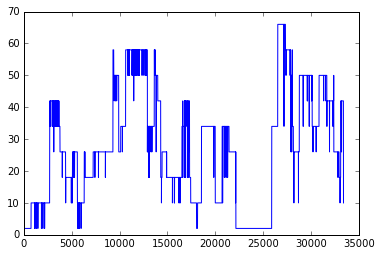

In [47]:
#import matplotlib.pyplot as plt

plt.plot(blop)
plt.show()

In [224]:
u, idx = np.unique(blop, return_index= True)

In [69]:
print X_1.Time_stamp[9239]
print X_1.Time_stamp[14999]
print X_1.Time_stamp[26519]
print X_1.Time_stamp[32279]

2016-03-02 10:00:00
2016-03-06 10:00:00
2016-03-14 10:00:00
2016-03-18 10:00:00


In [48]:
print X_1.shape[1] - np.sum(X_1.iloc[9307-7*60,:].isnull())

26


In [46]:
%matplotlib inline

## Counter

In [39]:
import os
os.chdir('/Users/marie/Documents/Capstone/Capstone_MachineLearning/New data/sensor files')
os.getcwd()

WindowsError: [Error 3] The system cannot find the path specified: '/Users/marie/Documents/Capstone/Capstone_MachineLearning/New data/sensor files'

In [117]:
humidity = pd.read_csv("20160329232406 to 20160401232729 B0B448B8A585 Humidity(rH).csv", header=None)

In [118]:
humidity.shape

(603101, 4)

In [119]:
humidity.head()

,0,1,2,3
0,2016-03-29 23:24:16.730,B0:B4:48:B8:A5:85,Humidity(rH),82.929581
1,2016-03-29 23:24:16.963,B0:B4:48:B8:A5:85,Humidity(rH),-1.017930
2,2016-03-29 23:24:17.696,B0:B4:48:B8:A5:85,Humidity(rH),82.929581
3,2016-03-29 23:24:17.989,B0:B4:48:B8:A5:85,Humidity(rH),-1.017930
4,2016-03-29 23:24:18.726,B0:B4:48:B8:A5:85,Humidity(rH),82.929581


In [142]:
c_h = Counter(humidity[3])
print c_h.most_common(3)

[(82.929580688476562, 301933), (-1.1628899574279783, 10465), (-1.1552605628967283, 8263)]


In [139]:
mattress = pd.read_csv("20160328170855 to 20160331171411 B0B448B8F204 Accelerometer(G).csv", header=None)

In [140]:
mattress.shape

(1528201, 14)

In [141]:
c_h = Counter(mattress[3])
print c_h.most_common(3)

[(-0.0, 81399), (0.02587890625, 36179), (0.025634765625, 35797)]


In [125]:
humidity_2 = pd.read_csv('20160402112805 to 20160405113116 B0B448B8A585 Humidity(rH).csv', header=None)

In [127]:
humidity.head()

,0,1,2,3
0,2016-03-29 23:24:16.730,B0:B4:48:B8:A5:85,Humidity(rH),82.929581
1,2016-03-29 23:24:16.963,B0:B4:48:B8:A5:85,Humidity(rH),-1.017930
2,2016-03-29 23:24:17.696,B0:B4:48:B8:A5:85,Humidity(rH),82.929581
3,2016-03-29 23:24:17.989,B0:B4:48:B8:A5:85,Humidity(rH),-1.017930
4,2016-03-29 23:24:18.726,B0:B4:48:B8:A5:85,Humidity(rH),82.929581


In [137]:
c_h_2 = Counter(humidity_2[3])
print c_h_2.most_common(3)

[(82.929580688476562, 302001), (-0.88822746276855469, 9401), (-0.78904390335083008, 8739)]


In [129]:
humidity_2.shape

(603248, 4)

In [130]:
mattress_2 = pd.read_csv('20160401051452 to 20160409121927 B0B448B8F204 Accelerometer(G).csv', header=None)

In [131]:
mattress_2.shape

(849009, 14)

In [132]:
mattress_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2016-04-01 05:11:34.103,B0:B4:48:B8:F2:04,Accelerometer(G),0.019287,0.001709,1.060059,Gyroscope(deg/s),-2.765625,0.375000,0.445312,Magnetometer(uT),0,0,0
1,2016-04-01 05:11:34.443,B0:B4:48:B8:F2:04,Accelerometer(G),-0.000000,0.000000,-0.000000,Gyroscope(deg/s),0.000000,0.000000,0.000000,Magnetometer(uT),0,0,0
2,2016-04-01 05:11:34.445,B0:B4:48:B8:F2:04,Accelerometer(G),0.018799,-0.066162,1.058105,Gyroscope(deg/s),-2.890625,0.781250,0.234375,Magnetometer(uT),0,0,0
3,2016-04-01 05:11:34.638,B0:B4:48:B8:F2:04,Accelerometer(G),0.016357,-0.063232,1.126221,Gyroscope(deg/s),-2.859375,0.523438,0.414062,Magnetometer(uT),0,0,0
4,2016-04-01 05:11:34.833,B0:B4:48:B8:F2:04,Accelerometer(G),0.017578,-0.065430,1.130127,Gyroscope(deg/s),-2.843750,0.500000,0.398438,Magnetometer(uT),0,0,0


In [136]:
c = Counter(mattress_2[3]**2+mattress_2[4]**2+mattress_2[5]**2)
print c.most_common(3)

[(0.0, 48423), (1.270159125328064, 76), (1.2723643183708191, 73)]


In [135]:
48423/849009.0 * 100

5.703473108058925

In [145]:
cb = Counter(mattress_2[3])
print cb.most_common(3)

[(-0.0, 48423), (0.025390625, 26764), (0.025634765625, 26753)]


In [147]:
toilet = pd.read_csv("20160329232406 to 20160401232729 B0B448D01606 Accelerometer(G).csv", header=None)

In [148]:
toilet.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2016-03-29 23:24:14.138,B0:B4:48:D0:16:06,Accelerometer(G),0.142822,1.006348,0.138184,Gyroscope(deg/s),-2.296875,-0.750000,0.867188,Magnetometer(uT),43.000000,-59.000000,-104.500000
1,2016-03-29 23:24:14.335,B0:B4:48:D0:16:06,Accelerometer(G),0.142822,1.004639,0.133545,Gyroscope(deg/s),-2.726562,-0.593750,0.703125,Magnetometer(uT),-1.666667,-60.333332,-104.500000
2,2016-03-29 23:24:14.569,B0:B4:48:D0:16:06,Accelerometer(G),0.143311,1.007324,0.135498,Gyroscope(deg/s),-2.351562,-0.632812,0.820312,Magnetometer(uT),-2.000000,-59.833332,-102.833336
3,2016-03-29 23:24:14.709,B0:B4:48:D0:16:06,Accelerometer(G),0.140137,1.008789,0.133057,Gyroscope(deg/s),-2.312500,-0.750000,-0.976562,Magnetometer(uT),-1.833333,-60.500000,-103.833336
4,2016-03-29 23:24:14.924,B0:B4:48:D0:16:06,Accelerometer(G),0.147705,1.005859,0.136230,Gyroscope(deg/s),-2.273438,-0.710938,0.812500,Magnetometer(uT),-0.166667,-59.166668,-103.833336


In [157]:
os.chdir('/Users/marie/Documents/Capstone/Capstone_MachineLearning/files Ludo/sensor files')
hum = pd.read_csv("20160302105921 to 20160318234803 B0B448B8A585 Humidity(rH).csv", header=None)

In [158]:
hum.shape

(1640840, 4)

In [159]:
c = Counter(hum[3])
c.most_common(3)

[(118.99427795410156, 31889),
 (-0.88822746276855469, 16775),
 (-0.82719135284423828, 16146)]

In [160]:
fourier = np.fft.fft(hum[3])
n = hum[3].size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
freq

array([  0.00000000e+00,   6.09443943e-06,   1.21888789e-05, ...,
        -1.82833183e-05,  -1.21888789e-05,  -6.09443943e-06])

In [170]:
os.chdir('/Users/marie/Documents/Capstone/Capstone_MachineLearning/New data/sensor files')
mat = pd.read_csv("20160328170855 to 20160331171411 B0B448B8F204 Accelerometer(G).csv", header=None)

In [171]:
mat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2016-03-28 17:08:55.405,B0:B4:48:B8:F2:04,Accelerometer(G),0.028809,0.005127,1.129395,Gyroscope(deg/s),-2.687500,0.820312,0.234375,Magnetometer(uT),0,0,0
1,2016-03-28 17:08:55.794,B0:B4:48:B8:F2:04,Accelerometer(G),-0.000000,0.000000,-0.000000,Gyroscope(deg/s),0.000000,0.000000,0.000000,Magnetometer(uT),0,0,0
2,2016-03-28 17:08:55.796,B0:B4:48:B8:F2:04,Accelerometer(G),-0.027100,0.003662,1.135742,Gyroscope(deg/s),-2.117188,2.046875,0.578125,Magnetometer(uT),0,0,0
3,2016-03-28 17:08:55.990,B0:B4:48:B8:F2:04,Accelerometer(G),-0.029053,0.006836,1.130371,Gyroscope(deg/s),-2.906250,0.640625,0.312500,Magnetometer(uT),0,0,0
4,2016-03-28 17:08:56.184,B0:B4:48:B8:F2:04,Accelerometer(G),-0.029053,0.008545,1.127930,Gyroscope(deg/s),-2.734375,0.687500,0.640625,Magnetometer(uT),0,0,0


In [172]:
c = Counter(np.sqrt(mat[3]**2+mat[4]**2+mat[4]**2))
c.most_common(3)

[(0.0, 81399), (0.032118181566329146, 2649), (0.030118484172293097, 2589)]

In [198]:
lengths = []
labels = y2
i=0
while i < len(labels):
    y_0 = labels.iloc[i]
    l = 1
    j=i+1
    while j < len(labels) and labels.iloc[j]==y_0 :
        l +=1
        j+=1
    i = j
    lengths.append(l)

In [200]:
sum(lengths)

17612

In [186]:
Counter(y2)

Counter({0: 11846, 1: 129, 2: 157, 3: 68, 4: 5376, 6: 36})

In [201]:
len(y2)

17612

In [38]:
from seqlearn.evaluation import SequenceKFold, whole_sequence_accuracy
kfold = SequenceKFold(lengths, n_folds=10, n_iter=1)

ImportError: No module named seqlearn.evaluation

In [214]:
Y = pd.DataFrame(y2).as_matrix()
X = X3.as_matrix()

In [129]:
from seqlearn.hmm import MultinomialHMM
multinomial_hmm_scores = []
for train_index, train_lengths, test_index, test_lengths in kfold:
    X_train, Y_train, X_test, Y_test = X1_final[train_index], y_1[train_index], X1_final[test_index], y_1[test_index]
    
    # Instantiate and Train Multinomial HMM
    clf1 = MultinomialHMM()
    clf1.fit(X_train,Y_train, train_lengths)

    Y_pred1 = clf1.predict(X_test, test_lengths)
    
    hmm_score = whole_sequence_accuracy(Y_test, Y_pred1, test_lengths)
    
    multinomial_hmm_scores.append(hmm_score)
 

ImportError: No module named seqlearn.hmm

In [218]:
multinomial_hmm_scores

[0.4444444444444444,
 0.5,
 0.5555555555555556,
 0.4285714285714286,
 0.3571428571428571,
 0.4,
 0.1428571428571429,
 0.4736842105263158,
 0.42105263157894735,
 0.44999999999999996]

In [39]:
import nltk
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer


In [48]:
# preprocess data
bar = pd.merge(X,y, on='Time_stamp')

In [45]:
trainer = nltk.tag.hmm.HiddenMarkovModelTrainer()

In [ ]:
trainer.train_supervised()

In [130]:
### determine class weights

In [283]:
foo = Counter(y_1)
print foo

Counter({0: 8122, 4: 3236, 2: 61, 1: 39, 3: 39, 6: 23})


In [284]:
print 8122.0/len(y_1)
print 39.0/len(y_1)
print 61.0/len(y_1)
print 50.0/len(y_1)
print 3236.0/len(y_1)
print 23.0/len(y_1)

0.705034722222
0.00338541666667
0.00529513888889
0.00434027777778
0.280902777778
0.00199652777778


{'Change': 0,
 'Cook': 1,
 'Eat': 2,
 'Other': 0,
 'Rice cooker': 1,
 'Shower': 3,
 'Sleep': 4,
 'TV': 5,
 'Toilet': 6}

In [50]:
cook = 0
sleep = 0
eat = 0
toilet = 0
shower = 0

bar = np.copy(Y1[33395-18*60:])

state = "other"

for i in xrange(len(bar)):
    if ((bar[i] == 1) and (state != "cook")):
        cook = cook + 1
        state = "cook"
    if ((bar[i] == 2) and (state != "eat")):
        eat = eat + 1
        state = "eat"
    if ((bar[i] == 3) and (state != "shower")):
        shower = shower + 1
        state = "shower"
    if ((bar[i] == 4) and (state != "sleep")):
        sleep = sleep +1
        state = "sleep"
    if ((bar[i] == 6) and (state != "toilet")):
        toilet = toilet + 1
        state = "toilet"
    if ((bar[i] == 0) and (state != "other")):
        state = "other"
print "Cook", cook
print "sleep ", sleep
print "eat",eat
print "toilet", toilet
print "shower", shower

Cook 0
sleep  0
eat 0
toilet 0
shower 0


In [281]:
cook = 0
sleep = 0
eat = 0
toilet = 0
shower = 0

bar = np.copy(y_1)

state = "other"

for i in xrange(len(bar)):
    if ((bar[i] == 1) and (state != "cook")):
        cook = cook + 1
        state = "cook"
    if ((bar[i] == 2) and (state != "eat")):
        eat = eat + 1
        state = "eat"
    if ((bar[i] == 3) and (state != "shower")):
        shower = shower + 1
        state = "shower"
    if ((bar[i] == 4) and (state != "sleep")):
        sleep = sleep +1
        state = "sleep"
    if ((bar[i] == 6) and (state != "toilet")):
        toilet = toilet + 1
        state = "toilet"
    if ((bar[i] == 0) and (state != "other")):
        state = "other"
print "Cook", cook
print "sleep ", sleep
print "eat",eat
print "toilet", toilet
print "shower", shower

Cook 3
sleep  7
eat 3
toilet 23
shower 7


In [ ]:
lengths = []
labels = y2
i=0
while i < len(labels):
    y_0 = labels.iloc[i]
    l = 1
    j=i+1
    while j < len(labels) and labels.iloc[j]==y_0 :
        l +=1
        j+=1
    i = j
    lengths.append(l)